In [70]:
# loading libraries
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
import joblib

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")


In [47]:
# Load all 3 files
def load_data(file_path, source):
    df = pd.read_csv(file_path, sep='\t', header=None, names=['sentence', 'label'])
    df['source'] = source
    return df

amazon_df = load_data('../data/amazon_cells_labelled.txt', 'amazon')
yelp_df = load_data('../data/yelp_labelled.txt', 'yelp')
imdb_df = load_data('../data/imdb_labelled.txt', 'imdb')

# Combine into one DataFrame
df = pd.concat([amazon_df, yelp_df, imdb_df]).reset_index(drop=True)

In [48]:
# View a sample of the data
print("Data shape:", df.shape, "\n")
df.sample(5)

Data shape: (2748, 3) 



,sentence,label,source
2021,If there was ever a movie that needed word-of-...,1,imdb
2252,"Wow, what a bad film.",0,imdb
1795,So good I am going to have to review this plac...,1,yelp
2521,"A Lassie movie which should have been ""put to ...",0,imdb
106,That's a huge design flaw (unless I'm not usin...,0,amazon


In [49]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())
# Check for duplicates
print("Duplicate rows:", df.duplicated().sum())

Missing values:
 sentence    0
label       0
source      0
dtype: int64
Duplicate rows: 17


**1. Basic EDA**

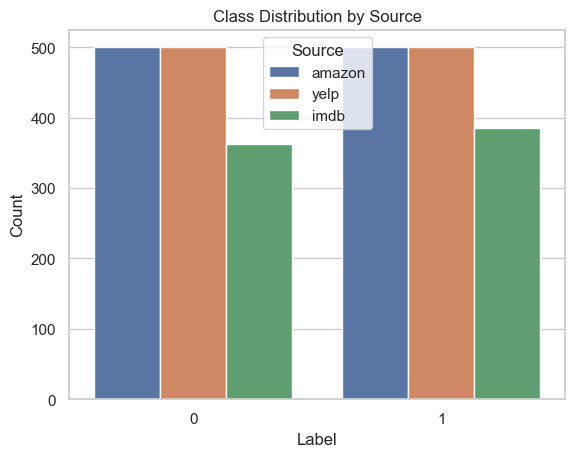

In [50]:
# Class distribution of labels across sources
sns.countplot(x='label', hue='source', data=df)
plt.title('Class Distribution by Source')
plt.xlabel('Label')
plt.ylabel('Count')
plt.legend(title='Source')
plt.show()

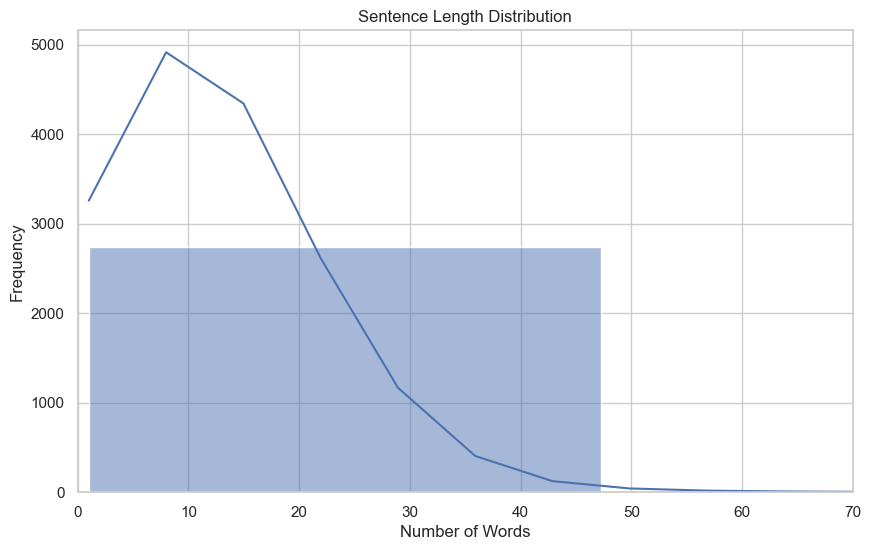

In [51]:
# Sentence length distribution
df['sentence_length'] = df['sentence'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['sentence_length'], bins=30, kde=True)
plt.title('Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 70)
plt.show()

**2. Text Preprocessing**

I will clean the text to remove noise and prepare it for vectorization:

In [52]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_text'] = df['sentence'].apply(clean_text)

In [53]:
# Inspect cleaned text
df[['sentence', 'cleaned_text']].sample(5)

,sentence,cleaned_text
2174,There was a few pathetic attempts to give the ...,pathetic attempts give characters depth didnt ...
9,What a waste of money and time!.,waste money time
917,Leopard Print is wonderfully wild!.,leopard print wonderfully wild
740,I would highly recommend this product.,would highly recommend product
1899,"Overall, a great experience.",overall great experience


In [54]:
df.sample()

,sentence,label,source,sentence_length,cleaned_text
839,I have bought this Nokia cell phone a few week...,0,amazon,16,bought nokia cell phone weeks ago nightmare


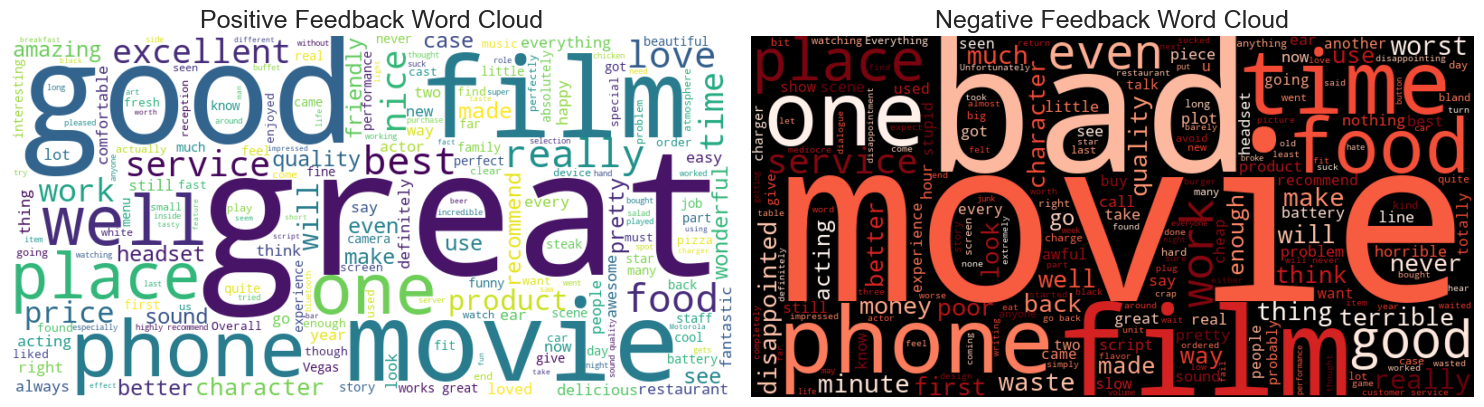

In [72]:
# Assuming your cleaned DataFrame is called `df`
positive_text = " ".join(df[df['label'] == 1]['sentence'])
negative_text = " ".join(df[df['label'] == 0]['sentence'])

# Generate word clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Plot side by side
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Feedback Word Cloud", fontsize=18)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Feedback Word Cloud", fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()

**3. TF-IDF Vectorization**

I'll convert the cleaned text into numerical features with `TfidfVectorizer`

In [55]:
# Create the vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # You can tweak max_features and ngrams

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['cleaned_text'])

# Target variable
y = df['label']

**4. Train/Test Split and Model Training**

I'll start with a few classic classifiers

In [56]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

# Collect metrics
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    results.append(evaluate_model(model, X_test, y_test, name))

# Create DataFrame
results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
results_df.reset_index(drop=True, inplace=True)

print(results_df)

                     Model  Accuracy  Precision    Recall  F1 Score
0  Multinomial Naive Bayes  0.829091   0.799296  0.859848  0.828467
1      Logistic Regression  0.836364   0.837209  0.818182  0.827586
2            Random Forest  0.809091   0.832636  0.753788  0.791252


**Model Comparison Breakdown**

| Model                     | Accuracy | Precision | Recall | F1 Score | Strengths                              | Weaknesses                            | Notes                                |
|--------------------------|----------|-----------|--------|----------|----------------------------------------|----------------------------------------|--------------------------------------|
| **Multinomial Naive Bayes** | 0.829    | 0.799     | **0.860** | **0.828** | High recall, good at catching positives | Slightly lower precision              | Simple, great baseline for text tasks |
| **Logistic Regression**  | **0.836** | **0.837** | 0.818  | 0.828    | Balanced, interpretable, stable         | Slightly lower recall than NB         | Great general-purpose model           |
| **Random Forest**        | 0.809    | 0.833     | 0.754  | 0.791    | Decent precision, captures patterns     | Lowest recall, risk of overfitting    | May not generalize well on small data |

- _Top F1 Score_: Naive Bayes (0.828), but Logistic Regression is right behind (0.827)

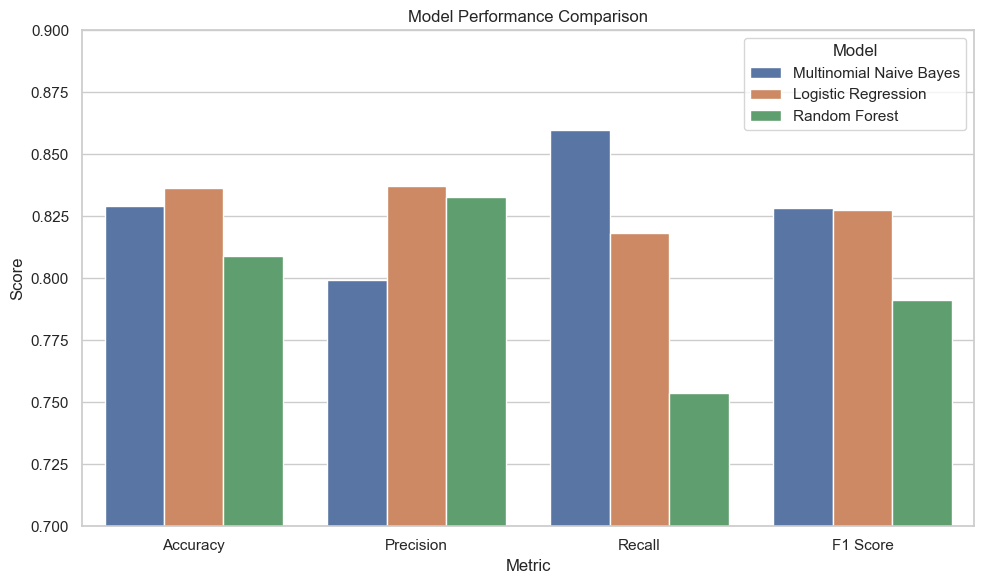

In [64]:
plt.figure(figsize=(10, 6))

# Melt the results DataFrame for easier plotting
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create barplot
sns.barplot(x='Metric', y='Score', hue='Model', data=results_melted)
plt.title('Model Performance Comparison')
plt.ylim(0.7, 0.9)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

Although Naive Bayes had a slightly higher F1 Score, Logistic Regression was chosen for deployment due to its more balanced performance across precision and recall.

In [69]:
# Select the best model of choice
best_model = models["Logistic Regression"]

# Save the selected model and vectorizer
joblib.dump(best_model, '../models/logistic_model.pkl')
joblib.dump(vectorizer, '../models/tfidf_vectorizer.pkl')

print("Saved Logistic Regression model and vectorizer.")

Saved Logistic Regression model and vectorizer.
